In [52]:
!pip install xgboost

^C
Traceback (most recent call last):
  File "/Users/ryangu/anaconda3/bin/pip", line 11, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/ryangu/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ryangu/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
           ^^^^^^^^^^^^^^^^
  File "/Users/ryangu/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 236, in _main
    self.handle_pip_version_check(options)
  File "/Users/ryangu/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/req_command.py", line 180, in handle_pip_version_check
    session = self._build_session(
              ^^^^^^^^^^^^^^^^^^^^
  File "/Users/ryangu/anaconda3/lib/python3.11/site-packages/pip/_internal/cli/req_command.py", line 125, in _build_session
    session = PipSession(


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.tree import plot_tree


# Loading in Data

In [ ]:
df = pd.read_csv("final_combine_and_rookie_data.csv")
#df.head()
#df.columns

# Train - Test Split

In [ ]:
y = df['pts']
combine_features = ['HGT', 'WGT', 'BMI', 'BF', 'WNGSPN',
                    'STNDRCH', 'STNDVERT', 'LPVERT',
                    'LANE', 'SPRINT', 'BENCH', 'BAR',
                    'PBHGT', 'PDHGT']
X = df[combine_features]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# PREDICTING POINTS

#### Linear Regression

In [ ]:
combine_features = [
    'HGT', 'WGT', 'BMI', 'BF', 'WNGSPN',
    'STNDRCH', 'STNDVERT', 'LPVERT',
    'LANE', 'SPRINT', 'BENCH', 'BAR',
    'PBHGT', 'PDHGT'
]
target_col = 'pts'

X_raw = df[combine_features].copy()
y_raw = df[target_col].copy()

for col in X_raw.columns:
    X_raw[col] = (
        X_raw[col]
        .astype(str)
        .str.replace('%', '', regex=False)  
        .str.strip()
    )
    X_raw[col] = pd.to_numeric(X_raw[col], errors='coerce')

y_raw = pd.to_numeric(y_raw, errors='coerce')

data_clean = pd.concat([X_raw, y_raw], axis=1).dropna()

X = data_clean[combine_features]
y = data_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Shapes after cleaning & split:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

train_df = X_train.copy()
train_df[target_col] = y_train
formula = target_col + " ~ " + " + ".join(combine_features)
model_smf = smf.ols(formula=formula, data=train_df).fit()

print("\nStatsmodels OLS Summary:")
print(model_smf.summary())
y_pred_train = model_smf.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nLinear Regression (SMF) TRAIN Results:")
print(f"TRAIN MSE  : {mse_train:.4f}")
print(f"TRAIN RMSE : {rmse_train:.4f}")
print(f"TRAIN R^2  : {r2_train:.4f}")

y_pred_test = model_smf.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("\nLinear Regression (SMF) TEST Results:")
print(f"TEST MSE  : {mse_test:.4f}")
print(f"TEST RMSE : {rmse_test:.4f}")
print(f"TEST R^2  : {r2_test:.4f}")


def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

VIF(X_train, combine_features)


Shapes after cleaning & split:
X_train: (328, 14) X_test: (83, 14)
y_train: (328,) y_test: (83,)

Statsmodels OLS Summary:
                            OLS Regression Results                            
Dep. Variable:                    pts   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.530
Date:                Mon, 08 Dec 2025   Prob (F-statistic):             0.0989
Time:                        16:31:23   Log-Likelihood:                -906.40
No. Observations:                 328   AIC:                             1843.
Df Residuals:                     313   BIC:                             1900.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

HGT         1475.243154
WGT          447.628777
BMI          217.616494
BF             1.879654
WNGSPN      1955.780974
STNDRCH       26.595073
STNDVERT     730.358936
LPVERT      1041.395012
LANE           1.493008
SPRINT         2.110712
BENCH          1.434321
BAR          533.952027
PBHGT       1951.679553
PDHGT       1619.408833
dtype: float64

##### After running the Linear Regression model, we found that it didn’t perform very well. The OSR² was only around 0.08, which means the model could explain only a small part of the variation in rookie points. Furthermore, if you look at p-values, you will notice that many variables are not statistically significant. In fact, according to the F-statistic, the model itself is not significant. We think the main reason is that combine stats only show a player’s physical abilities, but real NBA performance depends on many other things like playing time, team role, and how the coach uses the player. Since those factors aren’t in our data, the model can’t predict very accurately. In short, we see Linear Regression as a starting point, and we expect the next models to do better.

#### Feature Selection - Linear Regression

#### According to high VIF scores and some basic intuition regarding what variables would be highly correlated to each other, we removed accordingly to try and improve the model slightly.

In [ ]:
combine_features = [
    'HGT', 'BMI', 'BF', 'STNDVERT',
    'LANE', 'SPRINT', 'BENCH', 'BAR'
]
target_col = 'pts'  

X_raw = df[combine_features].copy()
y_raw = df[target_col].copy()

for col in X_raw.columns:
    X_raw[col] = (
        X_raw[col]
        .astype(str)
        .str.replace('%', '', regex=False)  
        .str.strip()
    )
    X_raw[col] = pd.to_numeric(X_raw[col], errors='coerce')

y_raw = pd.to_numeric(y_raw, errors='coerce')

data_clean = pd.concat([X_raw, y_raw], axis=1).dropna()

X = data_clean[combine_features]
y = data_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Shapes after cleaning & split:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

train_df = X_train.copy()
train_df[target_col] = y_train

formula = target_col + " ~ " + " + ".join(combine_features)
model_smf = smf.ols(formula=formula, data=train_df).fit()

print("\nStatsmodels OLS Summary:")
print(model_smf.summary())

y_pred_train = model_smf.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nLinear Regression (SMF) TRAIN Results:")
print(f"TRAIN MSE  : {mse_train:.4f}")
print(f"TRAIN RMSE : {rmse_train:.4f}")
print(f"TRAIN R^2  : {r2_train:.4f}")

y_pred_test = model_smf.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("\nLinear Regression (SMF) TEST Results:")
print(f"TEST MSE  : {mse_test:.4f}")
print(f"TEST RMSE : {rmse_test:.4f}")
print(f"TEST R^2  : {r2_test:.4f}")


def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

VIF(X_train, combine_features)

Shapes after cleaning & split:
X_train: (328, 8) X_test: (83, 8)
y_train: (328,) y_test: (83,)

Statsmodels OLS Summary:
                            OLS Regression Results                            
Dep. Variable:                    pts   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.542
Date:                Mon, 08 Dec 2025   Prob (F-statistic):              0.142
Time:                        16:31:23   Log-Likelihood:                -911.03
No. Observations:                 328   AIC:                             1840.
Df Residuals:                     319   BIC:                             1874.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------

HGT         1.543689
BMI         1.540042
BF          1.736082
STNDVERT    1.431778
LANE        1.409441
SPRINT      1.754247
BENCH       1.347637
BAR         1.101792
dtype: float64

#### You will notice that due to the feature selection, the VIF scores have fallen into an acceptable range. Yet, the model remains a poor predictor of rookie year point averages with an OSR² of ~0.07. Every variable besides SPRINT remains insignificant (@ 95% Confidence Interval) and the F-statistic shows that the model still remains statistically insignificant.

#### For the following models, we used the curated set of features from the 2nd linear regression model we ran

#### CART - Cross Validated using GridSearch

In [ ]:
X_train_cart = X_train[combine_features].copy()
X_test_cart  = X_test[combine_features].copy()

# Get a data-driven ccp_alpha grid from the pruning path
base_dt = DecisionTreeRegressor(random_state=42)
base_dt.fit(X_train_cart, y_train)

dt = DecisionTreeRegressor(random_state=42)

param_grid_dt = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "ccp_alpha": np.linspace(0, 0.01, 51),
}

cv_dt = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    scoring="neg_mean_squared_error",
    cv=cv_dt,
    n_jobs=1,
    verbose=0
)

grid_search_dt.fit(X_train_cart, y_train)

best_dt = grid_search_dt.best_estimator_

y_train_pred_dt = best_dt.predict(X_train_cart)
y_test_pred_dt  = best_dt.predict(X_test_cart)

train_mse_dt = mean_squared_error(y_train, y_train_pred_dt)
train_rmse_dt = np.sqrt(train_mse_dt)
train_r2_dt = r2_score(y_train, y_train_pred_dt)

test_mse_dt = mean_squared_error(y_test, y_test_pred_dt)
test_rmse_dt = np.sqrt(test_mse_dt)
test_r2_dt = r2_score(y_test, y_test_pred_dt)

print("\nDecision Tree (CART) TRAIN Results:")
print(f"TRAIN MSE  : {train_mse_dt:.4f}")
print(f"TRAIN RMSE : {train_rmse_dt:.4f}")
print(f"TRAIN R^2  : {train_r2_dt:.4f}")

print("\nDecision Tree (CART) TEST Results:")
print(f"TEST MSE  : {test_mse_dt:.4f}")
print(f"TEST RMSE : {test_rmse_dt:.4f}")
print(f"TEST R^2  : {test_r2_dt:.4f}")

print("\nBest params from GridSearchCV (Decision Tree):")
print(grid_search_dt.best_params_)
print(f"Best CV score (neg MSE): {grid_search_dt.best_score_:.4f}")

importances_dt = pd.Series(best_dt.feature_importances_, index=combine_features)
print("\nDecision Tree Feature Importances:")
print(importances_dt.sort_values(ascending=False))


CART (Decision Tree) with K-Fold CV and GridSearch

Decision Tree (CART) TRAIN Results:
TRAIN MSE  : 14.5996
TRAIN RMSE : 3.8209
TRAIN R^2  : 0.0715

Decision Tree (CART) TEST Results:
TEST MSE  : 12.1133
TEST RMSE : 3.4804
TEST R^2  : 0.0890

Best params from GridSearchCV (Decision Tree):
{'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV score (neg MSE): -17.4867

Decision Tree Feature Importances:
SPRINT      0.592951
BENCH       0.407049
HGT         0.000000
BMI         0.000000
BF          0.000000
STNDVERT    0.000000
LANE        0.000000
BAR         0.000000
dtype: float64


#### After running our Cross Validated Decision Tree, we found it to perform slighly better than our linear regression (OSR² of ~0.09)

#### Random Forest - Cross Validated with GridSearch

In [ ]:
X_train_rf = X_train[combine_features].copy()
X_test_rf  = X_test[combine_features].copy()

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=1
)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
    "ccp_alpha": np.linspace(0, 0.01, 11)
}

cv_rf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="neg_mean_squared_error",
    cv=cv_rf,
    n_jobs=1,
    verbose=0
)

grid_search_rf.fit(X_train_rf, y_train)

best_rf = grid_search_rf.best_estimator_

y_train_pred_rf = best_rf.predict(X_train_rf)
y_test_pred_rf  = best_rf.predict(X_test_rf)

train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(train_mse_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)

test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_rmse_rf = np.sqrt(test_mse_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\nRandom Forest TRAIN Results:")
print(f"TRAIN MSE  : {train_mse_rf:.4f}")
print(f"TRAIN RMSE : {train_rmse_rf:.4f}")
print(f"TRAIN R^2  : {train_r2_rf:.4f}")

print("\nRandom Forest TEST Results:")
print(f"TEST MSE  : {test_mse_rf:.4f}")
print(f"TEST RMSE : {test_rmse_rf:.4f}")
print(f"TEST R^2  : {test_r2_rf:.4f}")

print("\nBest params from GridSearchCV (Random Forest):")
print(grid_search_rf.best_params_)
print(f"Best CV score (neg MSE): {grid_search_rf.best_score_:.4f}")

importances_rf = pd.Series(best_rf.feature_importances_, index=combine_features)
print("\nRandom Forest Feature Importances:")
print(importances_rf.sort_values(ascending=False))



Random Forest TRAIN Results:
TRAIN MSE  : 10.0509
TRAIN RMSE : 3.1703
TRAIN R^2  : 0.3608

Random Forest TEST Results:
TEST MSE  : 12.2503
TEST RMSE : 3.5000
TEST R^2  : 0.0787

Best params from GridSearchCV (Random Forest):
{'ccp_alpha': 0.01, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score (neg MSE): -15.9088

Random Forest Feature Importances:
SPRINT      0.186471
LANE        0.136492
BAR         0.135702
BENCH       0.130453
BMI         0.113247
BF          0.103221
HGT         0.100480
STNDVERT    0.093934
dtype: float64


#### We found that the Random Forest tends to perform very similarly to our linear regression model with an OSR² of ~ 0.08. You will also notice when comparing the R² and the OSR² that the Random Forest seems to grossly overfit the data.

#### XGBoost - Cross Validated with GridSearch

In [ ]:
print("XGBoost with K-Fold CV and GridSearch")

X_train_xgb = X_train[combine_features].copy()
X_test_xgb  = X_test[combine_features].copy()

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=1
)

param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

cv_xgb = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="neg_mean_squared_error",
    cv=cv_xgb,
    n_jobs=1,
    verbose=0
)

grid_search_xgb.fit(X_train_xgb, y_train)

best_xgb = grid_search_xgb.best_estimator_

y_train_pred_xgb = best_xgb.predict(X_train_xgb)
y_test_pred_xgb  = best_xgb.predict(X_test_xgb)

train_mse_xgb = mean_squared_error(y_train, y_train_pred_xgb)
train_rmse_xgb = np.sqrt(train_mse_xgb)
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)

test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)
test_rmse_xgb = np.sqrt(test_mse_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

print("\nXGBoost TRAIN Results:")
print(f"TRAIN MSE  : {train_mse_xgb:.4f}")
print(f"TRAIN RMSE : {train_rmse_xgb:.4f}")
print(f"TRAIN R^2  : {train_r2_xgb:.4f}")

print("\nXGBoost TEST Results:")
print(f"TEST MSE  : {test_mse_xgb:.4f}")
print(f"TEST RMSE : {test_rmse_xgb:.4f}")
print(f"TEST R^2  : {test_r2_xgb:.4f}")

print("\nBest params from GridSearchCV (XGBoost):")
print(grid_search_xgb.best_params_)
print(f"Best CV score (neg MSE): {grid_search_xgb.best_score_:.4f}")

importances_xgb = pd.Series(best_xgb.feature_importances_, index=combine_features)
print("\nXGBoost Feature Importances:")
print(importances_xgb.sort_values(ascending=False))


XGBoost with K-Fold CV and GridSearch

XGBoost TRAIN Results:
TRAIN MSE  : 8.7467
TRAIN RMSE : 2.9575
TRAIN R^2  : 0.4437

XGBoost TEST Results:
TEST MSE  : 12.3775
TEST RMSE : 3.5182
TEST R^2  : 0.0691

Best params from GridSearchCV (XGBoost):
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best CV score (neg MSE): -16.7159

XGBoost Feature Importances:
BENCH       0.161195
SPRINT      0.154710
BAR         0.149638
HGT         0.121371
LANE        0.120180
STNDVERT    0.105346
BMI         0.096736
BF          0.090822
dtype: float32


#### The XGBoost performed quite poorly as well with an OSR² of ~ 0.07. Similar to the Random Forest, XGBoost overfit the data heavily

#### Visualization Section:

#### Random Forest Tree

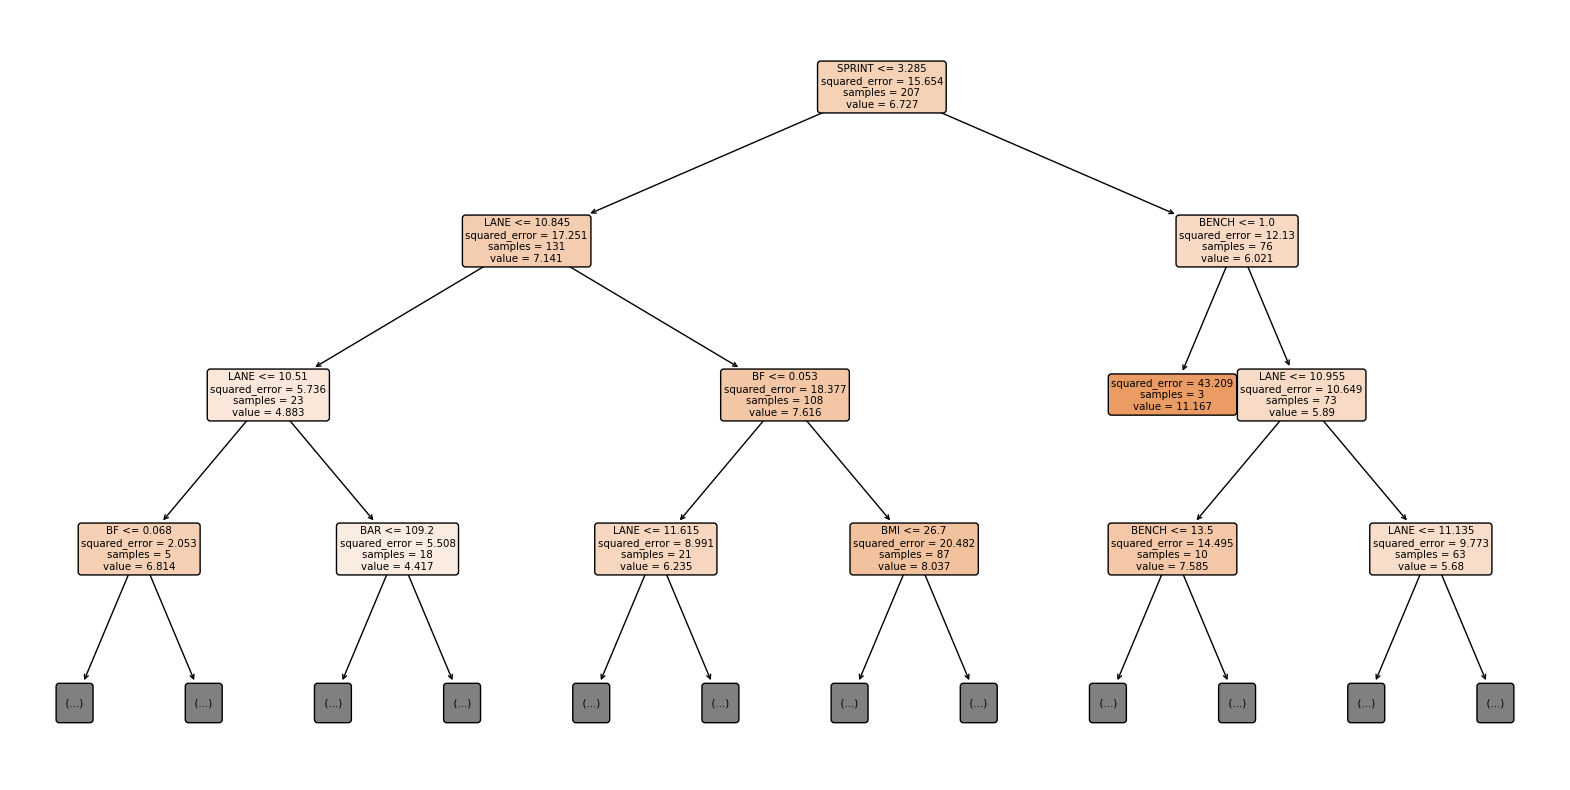

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(best_rf.estimators_[0],
          feature_names=combine_features,
          filled=True,
          rounded=True,
          max_depth=3)
plt.show()

#### CART Tree

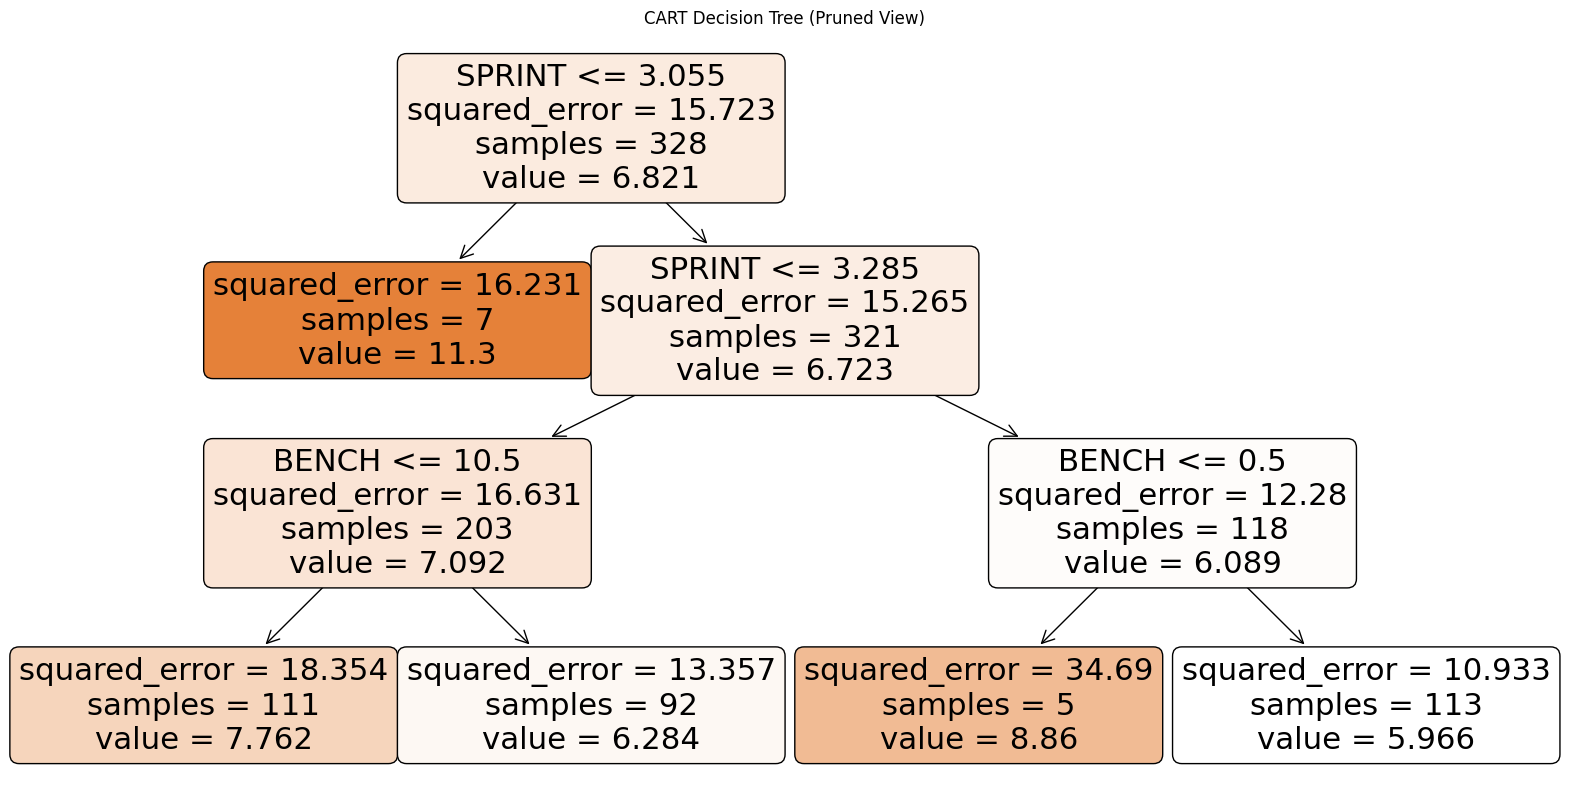

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt,
    feature_names=combine_features,
    filled=True,
    rounded=True,
    max_depth=3
)
plt.title("CART Decision Tree (Pruned View)")
plt.show()


#### XGBoost Tree

<Figure size 9000x4500 with 0 Axes>

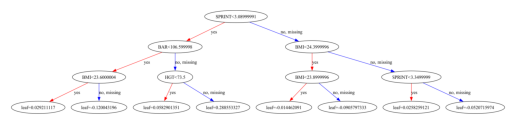

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 15), dpi=300)
plot_tree(best_xgb, num_trees=0)
plt.show()

#### Model Comparison Table (Points)

In [ ]:
results = {
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "XGBoost"],
    "MSE": [12.3589, 12.1133, 12.2503, 12.3775],
    "RMSE": [3.5155, 3.4804, 3.5000, 3.5182],
    "OSR2": [0.0705, 0.0890, 0.0787, 0.0691]
}

df_results = pd.DataFrame(results)
df_results

,Model,MSE,RMSE,OSR2
0,Linear Regression,12.3589,3.5155,0.0705
1,Decision Tree,12.1133,3.4804,0.0890
2,Random Forest,12.2503,3.5000,0.0787
3,XGBoost,12.3775,3.5182,0.0691


#### It is clear based on the above comparison table that the Decision Tree (CART) performed the best. Although, none of the models seemed to have much predictive power

,Model,Test MSE,Test RMSE,Test R2
0,Linear Regression (OLS - 8 features),12.358857,3.515517,0.070516
1,Decision Tree (CART),12.113263,3.480411,0.088986
2,Random Forest,12.250263,3.500038,0.078683
3,XGBoost,12.377451,3.518160,0.069117


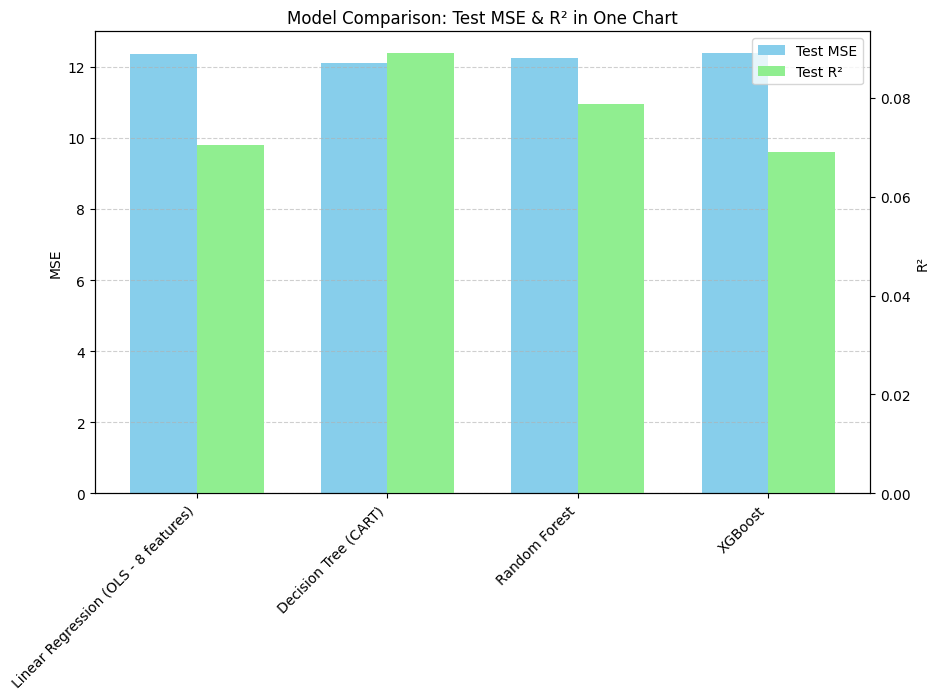

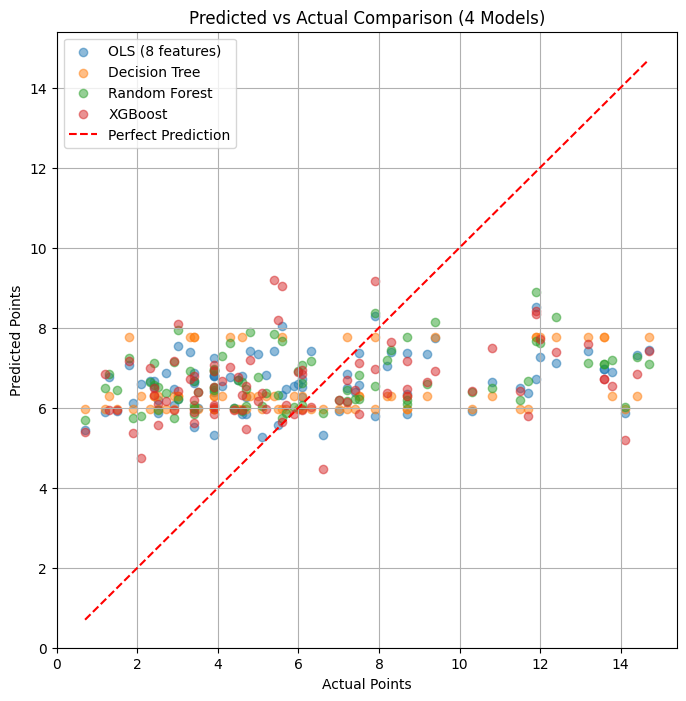

In [ ]:
results = {
    "Model": [
        "Linear Regression (OLS - 8 features)",
        "Decision Tree (CART)",
        "Random Forest",
        "XGBoost"
    ],

    "Test MSE": [
        mse_test,
        test_mse_dt,
        test_mse_rf,
        test_mse_xgb
    ],

    "Test RMSE": [
        rmse_test,
        test_rmse_dt,
        test_rmse_rf,
        test_rmse_xgb
    ],

    "Test R2": [
        r2_test,
        test_r2_dt,
        test_r2_rf,
        test_r2_xgb
    ]
}

df_results = pd.DataFrame(results)
display(df_results)

models = df_results["Model"]

mse_vals = df_results["Test MSE"]
r2_vals = df_results["Test R2"]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis — MSE
ax1.bar(x - width/2, mse_vals, width, label="Test MSE", color="skyblue")
ax1.set_ylabel("MSE")
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha="right")
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.bar(x + width/2, r2_vals, width, label="Test R²", color="lightgreen")
ax2.set_ylabel("R²")

lines = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ["Test MSE", "Test R²"]
plt.legend(lines, labels, loc="upper right")

plt.title("Model Comparison: Test MSE & R² in One Chart")
plt.show()


plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred_test, alpha=0.5, label="OLS (8 features)")
plt.scatter(y_test, y_test_pred_dt, alpha=0.5, label="Decision Tree")
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, label="Random Forest")
plt.scatter(y_test, y_test_pred_xgb, alpha=0.5, label="XGBoost")

min_val = min(y_test.min(), y_test.min())
max_val = max(y_test.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")

plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Predicted vs Actual Comparison (4 Models)")
plt.legend()
plt.grid(True)
plt.show()


### Given how poor of a predictor the models were on points, we decided to see if the models could predict rebounds better becuase physical attributes such as height, weight and the physical tests such as standing vertical tend to be better measures of how well someone could rebound

# PREDICTING REBOUNDS

In [ ]:
target_col = 'reb'    

combine_features = ['HGT','BMI','BF','STNDVERT','LANE','SPRINT','BENCH','BAR']

X_raw_reb = df[combine_features].copy()
y_raw_reb = df[target_col].copy()

# Clean data (same process as pts)
for col in X_raw_reb.columns:
    X_raw_reb[col] = (
        X_raw_reb[col]
        .astype(str)
        .str.replace('%','', regex=False)
        .str.strip()
    )
    X_raw_reb[col] = pd.to_numeric(X_raw_reb[col], errors='coerce')

y_raw_reb = pd.to_numeric(y_raw_reb, errors='coerce')

data_clean_reb = pd.concat([X_raw_reb, y_raw_reb], axis=1).dropna()

X_reb = data_clean_reb[combine_features]
y_reb = data_clean_reb[target_col]

X_train_reb, X_test_reb, y_train_reb, y_test_reb = train_test_split(
    X_reb, y_reb, test_size=0.2, random_state=42
)

print("Shapes after cleaning & split (REB):")
print("X_train:", X_train_reb.shape, "X_test:", X_test_reb.shape)
print("y_train:", y_train_reb.shape, "y_test:", y_test_reb.shape)


 REBOUNDS ANALYSIS — FEATURE CLEANING 

Shapes after cleaning & split (REB):
X_train: (328, 8) X_test: (83, 8)
y_train: (328,) y_test: (83,)


#### Linear Regression

In [ ]:
train_df_reb = X_train_reb.copy()
train_df_reb[target_col] = y_train_reb

formula_reb = target_col + " ~ " + " + ".join(combine_features)
model_smf_reb = smf.ols(formula=formula_reb, data=train_df_reb).fit()

print(model_smf_reb.summary())

y_train_pred_reb = model_smf_reb.predict(X_train_reb)
mse_train_reb = mean_squared_error(y_train_reb, y_train_pred_reb)
rmse_train_reb = np.sqrt(mse_train_reb)
r2_train_reb = r2_score(y_train_reb, y_train_pred_reb)

y_pred_test_reb = model_smf_reb.predict(X_test_reb)
mse_test_reb = mean_squared_error(y_test_reb, y_pred_test_reb)
rmse_test_reb = np.sqrt(mse_test_reb)
r2_test_reb = r2_score(y_test_reb, y_pred_test_reb)

print("\nOLS (REB) TRAIN Results:")
print(f"TRAIN MSE  : {mse_train_reb:.4f}")
print(f"TRAIN RMSE : {rmse_train_reb:.4f}")
print(f"TRAIN R^2  : {r2_train_reb:.4f}")

print("\nOLS (REB) TEST Results:")
print(f"TEST MSE  : {mse_test_reb:.4f}")
print(f"TEST RMSE : {rmse_test_reb:.4f}")
print(f"TEST R^2  : {r2_test_reb:.4f}")


 LINEAR REGRESSION (REB) — OLS

                            OLS Regression Results                            
Dep. Variable:                    reb   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     15.42
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           3.59e-19
Time:                        16:32:11   Log-Likelihood:                -612.76
No. Observations:                 328   AIC:                             1244.
Df Residuals:                     319   BIC:                             1278.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -24.11

#### This model performs much better than points. The F-statistic informs us that the model is statistically significant and our OSR² is much higher when predicting rebounds (~0.25)

#### CART - Cross Validated with GridSearch

In [59]:
param_grid_dt_reb = {
    'max_depth': [2, 3, 4, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5], 
    'ccp_alpha': np.linspace(0,0.1,51)
}

cv_dt_reb = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_dt_reb = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_dt_reb,
    scoring='neg_mean_squared_error',
    cv=cv_dt_reb,
    n_jobs=1
)

grid_search_dt_reb.fit(X_train_reb, y_train_reb)

best_dt_reb = grid_search_dt_reb.best_estimator_

y_train_pred_dt_reb = best_dt_reb.predict(X_train_reb)
train_mse_dt_reb = mean_squared_error(y_train_reb, y_train_pred_dt_reb)
train_rmse_dt_reb = np.sqrt(train_mse_dt_reb)
train_r2_dt_reb = r2_score(y_train_reb, y_train_pred_dt_reb)

y_test_pred_dt_reb = best_dt_reb.predict(X_test_reb)
test_mse_dt_reb = mean_squared_error(y_test_reb, y_test_pred_dt_reb)
test_rmse_dt_reb = np.sqrt(test_mse_dt_reb)
test_r2_dt_reb = r2_score(y_test_reb, y_test_pred_dt_reb)

print("Best CART params:", grid_search_dt_reb.best_params_)
print(f"TRAIN MSE:  {train_mse_dt_reb:.4f}")
print(f"TRAIN RMSE: {train_rmse_dt_reb:.4f}")
print(f"TRAIN R2:   {train_r2_dt_reb:.4f}")
print(f"TEST MSE:   {test_mse_dt_reb:.4f}")
print(f"TEST RMSE:  {test_rmse_dt_reb:.4f}")
print(f"TEST R2:    {test_r2_dt_reb:.4f}")

importances_dt_reb = pd.Series(best_dt_reb.feature_importances_, index=combine_features)
print("\nDecision Tree Feature Importances:")
print(importances_dt_reb.sort_values(ascending=False))



Best CART params: {'ccp_alpha': 0.0, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
TRAIN MSE:  2.5265
TRAIN RMSE: 1.5895
TRAIN R2:   0.2581
TEST MSE:   2.0583
TEST RMSE:  1.4347
TEST R2:    0.1123

Decision Tree Feature Importances:
HGT         1.0
BMI         0.0
BF          0.0
STNDVERT    0.0
LANE        0.0
SPRINT      0.0
BENCH       0.0
BAR         0.0
dtype: float64


#### Our Decision Tree performed worse than our Linear Regression with an OSR² of ~ 0.11

#### Random Forest

In [57]:
param_grid_rf_reb = {
    'n_estimators': [100, 200],
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt', 'log2', None], 
    'ccp_alpha': np.linspace(0, 0.01, 11)
}

cv_rf_reb = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf_reb = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=1),
    param_grid_rf_reb,
    scoring='neg_mean_squared_error',
    cv=cv_rf_reb,
    n_jobs=1
)

grid_search_rf_reb.fit(X_train_reb, y_train_reb)

best_rf_reb = grid_search_rf_reb.best_estimator_

y_train_pred_rf_reb = best_rf_reb.predict(X_train_reb)
train_mse_rf_reb = mean_squared_error(y_train_reb, y_train_pred_rf_reb)
train_rmse_rf_reb = np.sqrt(train_mse_rf_reb)
train_r2_rf_reb = r2_score(y_train_reb, y_train_pred_rf_reb)

y_test_pred_rf_reb = best_rf_reb.predict(X_test_reb)
test_mse_rf_reb = mean_squared_error(y_test_reb, y_test_pred_rf_reb)
test_rmse_rf_reb = np.sqrt(test_mse_rf_reb)
test_r2_rf_reb = r2_score(y_test_reb, y_test_pred_rf_reb)

print("Best RF params:", grid_search_rf_reb.best_params_)
print(f"TRAIN MSE:  {train_mse_rf_reb:.4f}")
print(f"TRAIN RMSE: {train_rmse_rf_reb:.4f}")
print(f"TRAIN R2:   {train_r2_rf_reb:.4f}")
print(f"TEST MSE:   {test_mse_rf_reb:.4f}")
print(f"TEST RMSE:  {test_rmse_rf_reb:.4f}")
print(f"TEST R2:    {test_r2_rf_reb:.4f}")

importances_rf_reb = pd.Series(best_rf_reb.feature_importances_, index=combine_features)
print("\nRandom Forest Feature Importances:")
print(importances_rf_reb.sort_values(ascending=False))



Best RF params: {'ccp_alpha': 0.01, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
TRAIN MSE:  1.9718
TRAIN RMSE: 1.4042
TRAIN R2:   0.4210
TEST MSE:   2.0074
TEST RMSE:  1.4168
TEST R2:    0.1342

Random Forest Feature Importances:
HGT         0.620673
BENCH       0.102595
BMI         0.084446
LANE        0.053159
BAR         0.051436
BF          0.032665
SPRINT      0.027863
STNDVERT    0.027164
dtype: float64


#### The Random Forest performs worse than the linear regression but still better than the CART model with an OSR² of ~ 0.13

#### XGBoost - Cross Validated with GridSearch

In [60]:
param_grid_xgb_reb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

cv_xgb_reb = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_xgb_reb = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid_xgb_reb,
    scoring='neg_mean_squared_error',
    cv=cv_xgb_reb,
    n_jobs=1
)

grid_search_xgb_reb.fit(X_train_reb, y_train_reb)

best_xgb_reb = grid_search_xgb_reb.best_estimator_

y_train_pred_xgb_reb = best_xgb_reb.predict(X_train_reb)
train_mse_xgb_reb = mean_squared_error(y_train_reb, y_train_pred_xgb_reb)
train_rmse_xgb_reb = np.sqrt(train_mse_xgb_reb)
train_r2_xgb_reb = r2_score(y_train_reb, y_train_pred_xgb_reb)

y_test_pred_xgb_reb = best_xgb_reb.predict(X_test_reb)
test_mse_xgb_reb = mean_squared_error(y_test_reb, y_test_pred_xgb_reb)
test_rmse_xgb_reb = np.sqrt(test_mse_xgb_reb)
test_r2_xgb_reb = r2_score(y_test_reb, y_test_pred_xgb_reb)

print("Best XGB params:", grid_search_xgb_reb.best_params_)
print(f"TRAIN MSE:  {train_mse_xgb_reb:.4f}")
print(f"TRAIN RMSE: {train_rmse_xgb_reb:.4f}")
print(f"TRAIN R2:   {train_r2_xgb_reb:.4f}")
print(f"TEST MSE:   {test_mse_xgb_reb:.4f}")
print(f"TEST RMSE:  {test_rmse_xgb_reb:.4f}")
print(f"TEST R2:    {test_r2_xgb_reb:.4f}")

importances_xgb_reb = pd.Series(best_xgb_reb.feature_importances_, index=combine_features)
print("\nDecision Tree Feature Importances:")
print(importances_xgb_reb.sort_values(ascending=False))



Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
TRAIN MSE:  1.2101
TRAIN RMSE: 1.1000
TRAIN R2:   0.6447
TEST MSE:   2.0401
TEST RMSE:  1.4283
TEST R2:    0.1201

Decision Tree Feature Importances:
HGT         0.264210
BENCH       0.124386
BMI         0.120609
LANE        0.106876
STNDVERT    0.101109
SPRINT      0.100312
BAR         0.091383
BF          0.091116
dtype: float32


#### The XGBoost performs right in between the CART and Random Forest with an OSR² of ~ 0.12

#### Visualizations:

#### Random Forest Tree

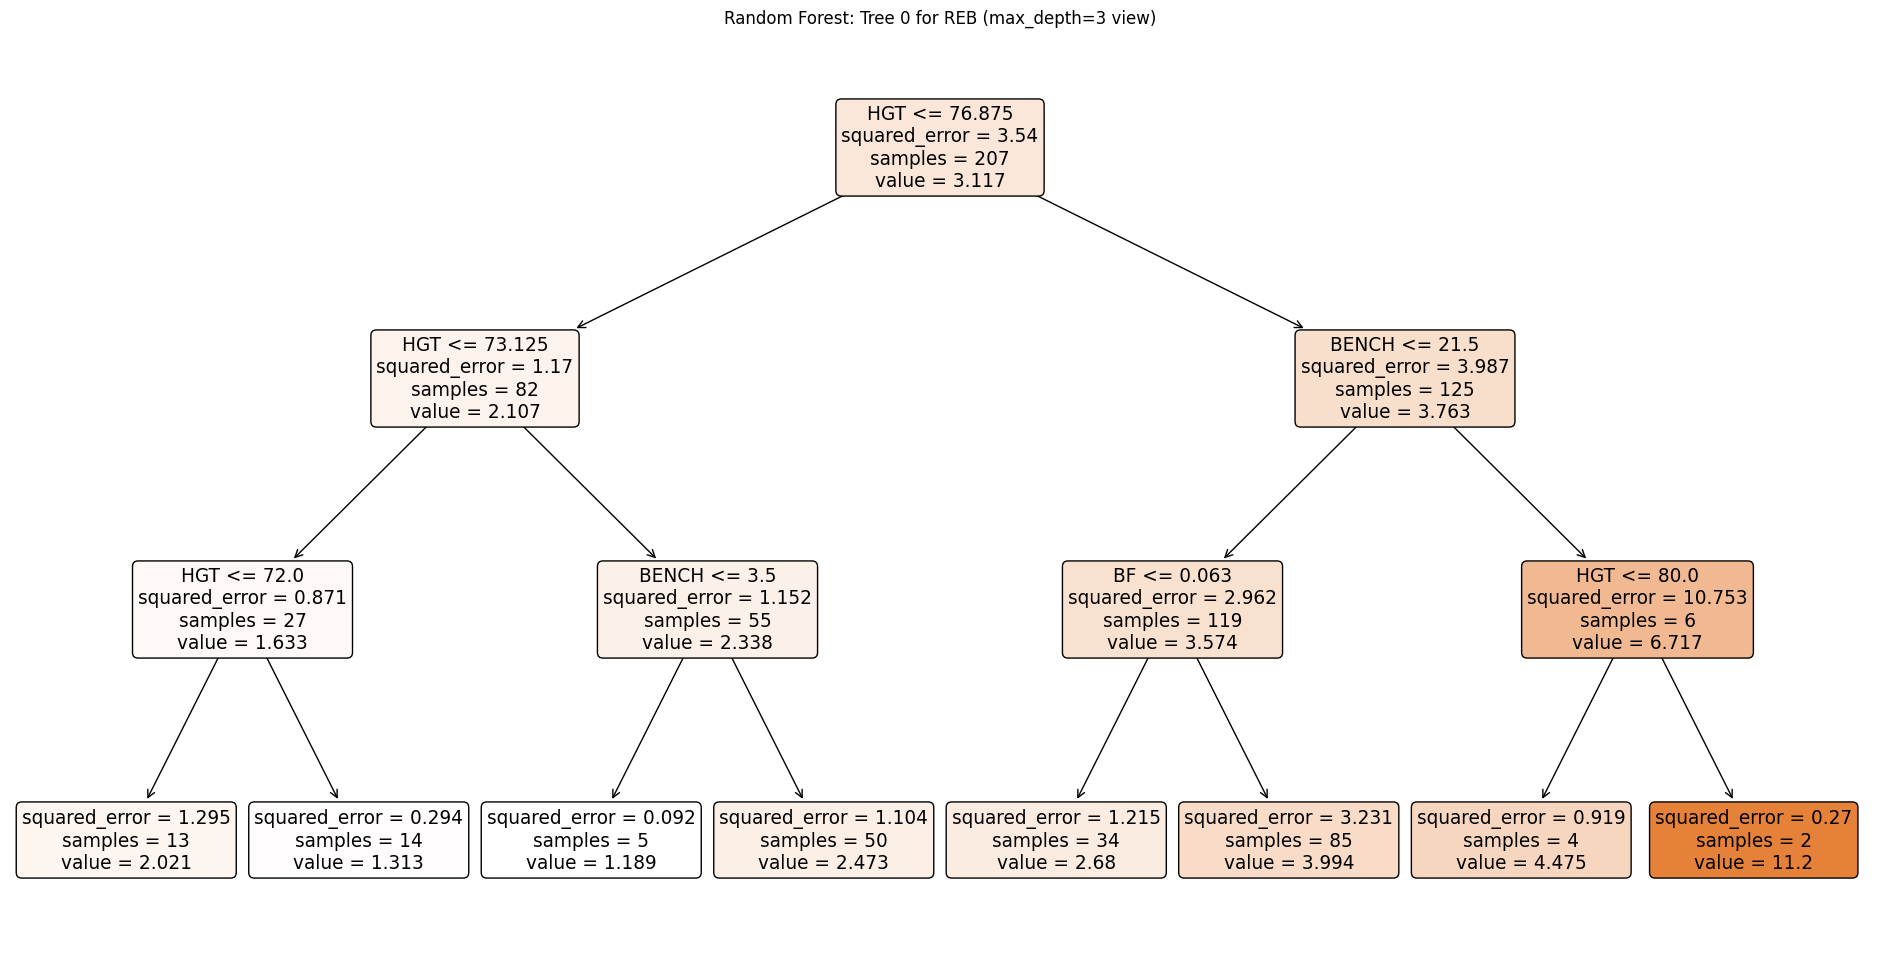

In [73]:
from sklearn.tree import plot_tree

one_tree = best_rf_reb.estimators_[0]

plt.figure(figsize=(24, 12))
plot_tree(
    one_tree,
    feature_names=combine_features,
    filled=True,
    rounded=True,
    max_depth=3   # keep small so it's readable
)
plt.title("Random Forest: Tree 0 for REB (max_depth=3 view)")
plt.show()

#### CART Tree

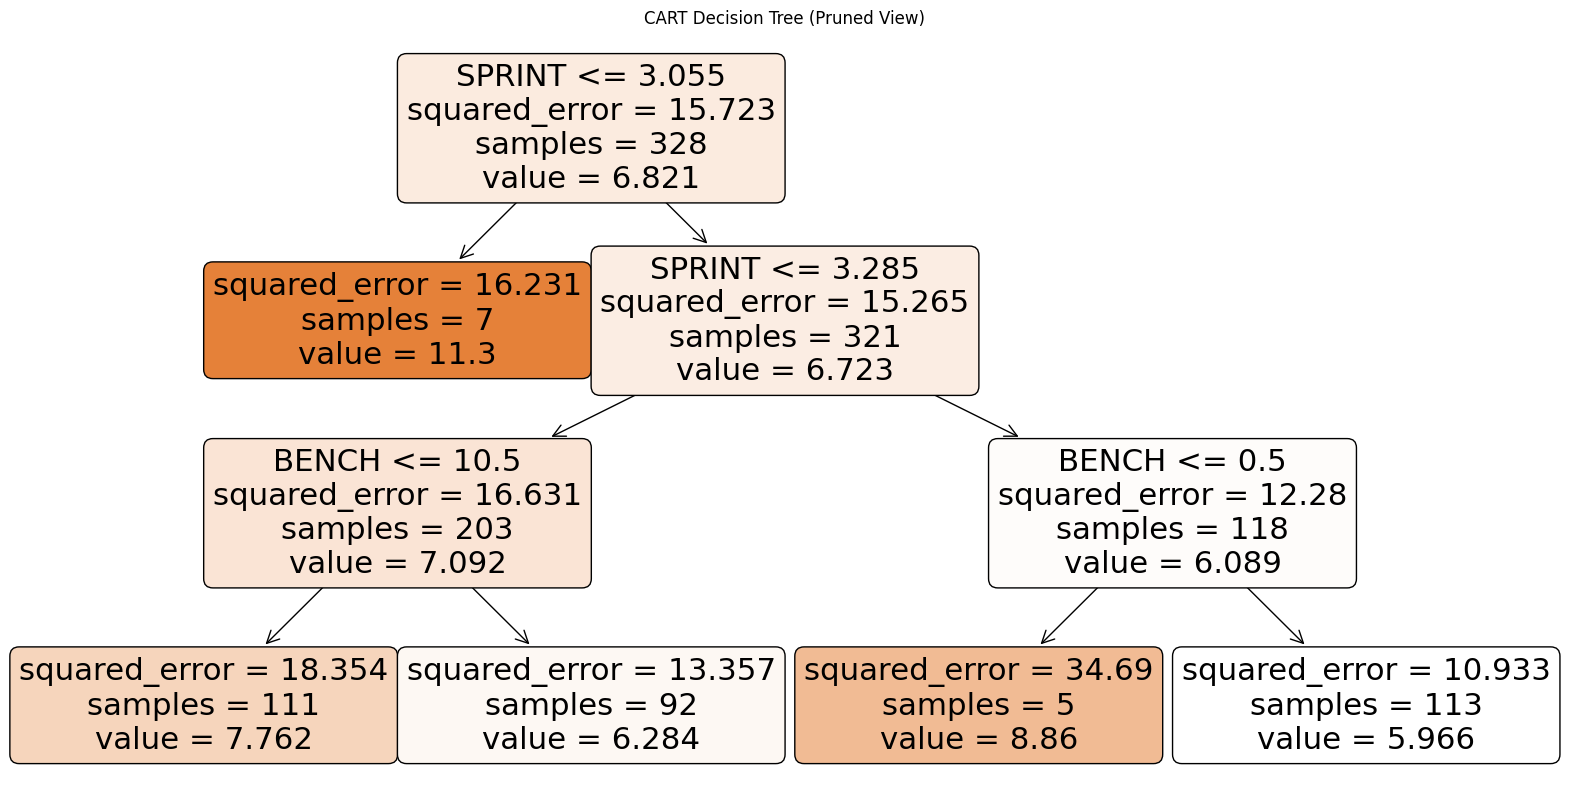

In [76]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt,
    feature_names=combine_features,
    filled=True,
    rounded=True,
    max_depth=3
)
plt.title("CART Decision Tree (Pruned View)")
plt.show()

#### XGBoost Tree

<Figure size 10800x6000 with 0 Axes>

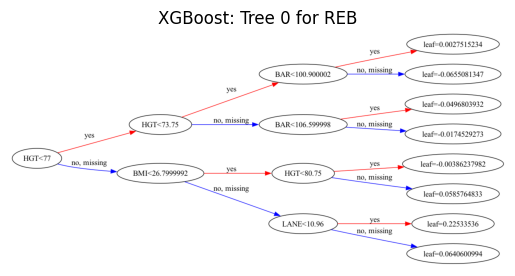

In [79]:
from xgboost import plot_tree

plt.figure(figsize=(36, 20), dpi=300)
plot_tree(
    best_xgb_reb,
    num_trees=0,      # first tree in the boosted sequence
    rankdir='LR'      # left-to-right for readability
)
plt.title("XGBoost: Tree 0 for REB")
plt.show()

,Model,Test MSE,Test RMSE,Test R2
0,OLS (REB),1.741107,1.319510,0.249066
1,Decision Tree (REB),2.058253,1.434661,0.112282
2,Random Forest (REB),2.007401,1.416828,0.134214
3,XGBoost (REB),2.040092,1.428318,0.120115


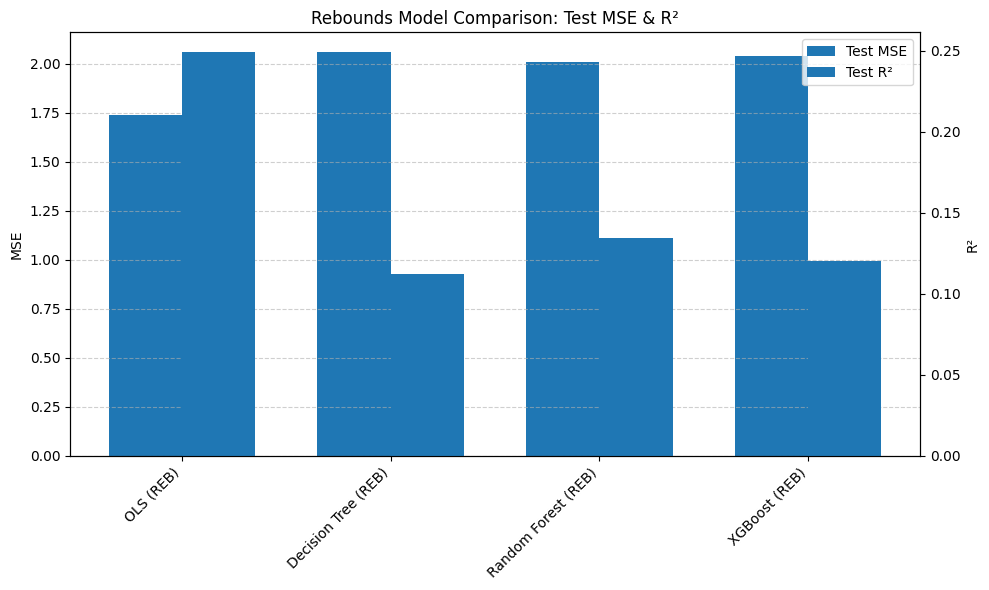

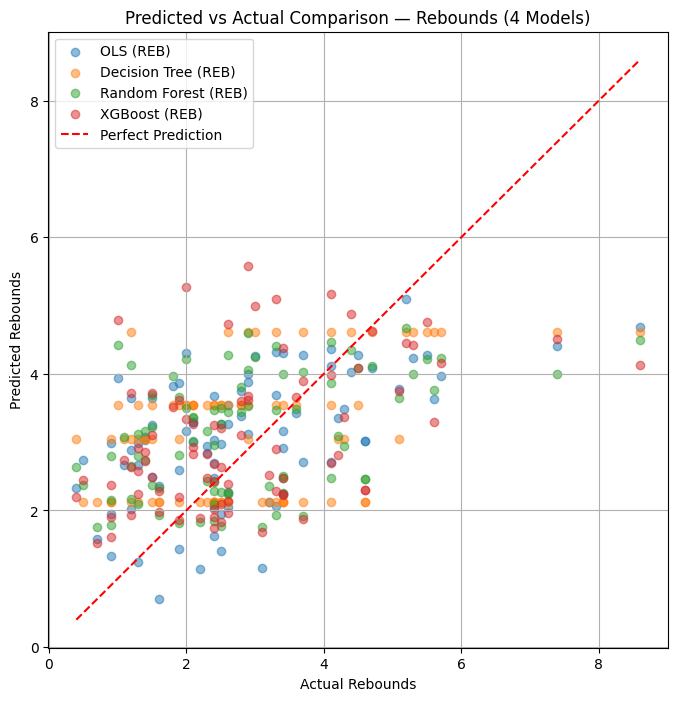

In [72]:
results_reb = {
    "Model": [
        "OLS (REB)",
        "Decision Tree (REB)",
        "Random Forest (REB)",
        "XGBoost (REB)"
    ],
    "Test MSE": [
        mse_test_reb,
        test_mse_dt_reb,
        test_mse_rf_reb,
        test_mse_xgb_reb
    ],
    "Test RMSE": [
        rmse_test_reb,
        np.sqrt(test_mse_dt_reb),
        np.sqrt(test_mse_rf_reb),
        np.sqrt(test_mse_xgb_reb)
    ],
    "Test R2": [
        r2_test_reb,
        test_r2_dt_reb,
        test_r2_rf_reb,
        test_r2_xgb_reb
    ]
}

df_results_reb = pd.DataFrame(results_reb)
display(df_results_reb)

models_reb = df_results_reb["Model"]
mse_vals_reb = df_results_reb["Test MSE"]
r2_vals_reb = df_results_reb["Test R2"]

x = np.arange(len(models_reb))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(x - width/2, mse_vals_reb, width, label="Test MSE")
ax1.set_ylabel("MSE")
ax1.set_xticks(x)
ax1.set_xticklabels(models_reb, rotation=45, ha="right")
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.bar(x + width/2, r2_vals_reb, width, label="Test R²")
ax2.set_ylabel("R²")

lines = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ["Test MSE", "Test R²"]
plt.legend(lines, labels, loc="upper right")

plt.title("Rebounds Model Comparison: Test MSE & R²")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test_reb, y_pred_test_reb, alpha=0.5, label="OLS (REB)")
plt.scatter(y_test_reb, y_test_pred_dt_reb, alpha=0.5, label="Decision Tree (REB)")
plt.scatter(y_test_reb, y_test_pred_rf_reb, alpha=0.5, label="Random Forest (REB)")
plt.scatter(y_test_reb, y_test_pred_xgb_reb, alpha=0.5, label="XGBoost (REB)")

min_val_reb = y_test_reb.min()
max_val_reb = y_test_reb.max()
plt.plot([min_val_reb, max_val_reb], [min_val_reb, max_val_reb],
         'r--', label="Perfect Prediction")

plt.xlabel("Actual Rebounds")
plt.ylabel("Predicted Rebounds")
plt.title("Predicted vs Actual Comparison — Rebounds (4 Models)")
plt.legend()
plt.grid(True)
plt.show()


#### In our analysis of Rebounds, we found that the linear regression was the most powerful tool. Most of the models performed similarly on rebounds as they did on points, showing us that combine statistics remain a poor indicator of rookie year performance